# Alternative Approaches to RedPitaya Bode Analyser

This article explores two alternative approaches to improving the [Bode Analyser](https://redpitaya.readthedocs.io/en/latest/appsFeatures/applications/bode/bode.html),
a web tool included in the default suite of RedPitaya applications.

RedPitaya offers a Bode plot web application for analyzing the frequency response of a system.
However, it comes with several limitations that can be addressed if we have full control over
the input and output of the analyzed system. The current shortcomings include:

1. **Iterative Frequency Sweep with Discontinuity**: The frequency sweep lacks continuity and requires iterative approach.
2. **Increased Analysis Time with Higher Step Count**: Overall frequency response analysis time rises with an increased number of steps.
3. **Limited Data Export Options**: Data export options are restricted, providing only a resulting CSV with magnitude and phase data, without input or output information.
4. **Inability to Apply Scaling Factor on Analog Input**: There is no provision to apply a scaling factor on analog input, controlled by the LV/HV [jumper switch](https://redpitaya.readthedocs.io/en/latest/developerGuide/hardware/125-14/fastIO.html)), leading to inaccurately biased Bode plots.

In most cases, the above disadvantages are not significant and the plot produced by Bode
Analyzer is useful for frequency response analysis, but using the full power of the Python
interface to RedPitaya when generating or sampling waveforms, we can achieve more interesting
results and obviously learn something new.

## Analysed System

In this article, a signal filter with the following characteristics will be analyzed:

- Butterworth, Bandpass, 8th order
- Passband gain: 0 dB
- Stopband attenuation: 40 dB
- Center frequency: 40 kHz
- Passband frequency: 10 kHz
- Stopband frequency: 40 kHz

These characteristics were achieved using the [LTC1562](https://www.analog.com/media/en/technical-documentation/data-sheets/1562fa.pdf)
active filter device. The filter was designed using [FilterCAD](https://www.analog.com/en/resources/design-notes/free-filtercad-designs-filters-quickly-and-easily.html) software, resulting in the following theoretical frequency response plot:

![Bandpass filter](./img/filtercad-filter-design.png "Bandpass filter")

*Figure 1*

This theoretical Bode plot will serve as a reference for comparison with the plot
generated by the Bode Analyzer application from RedPitaya.

### Bode Analyser plot

The system described above was initially analyzed using the Bode Analyser application
shipped with RedPitaya, resulting in the following frequency response plot:

![Bode Analyser plot](./img/rp-bode.png "Bode Analyser plot")

*Figure 2*

At a quick glance it is evident that theoretical predictions closely align with practical results:
the magnitude and phase plots of the filter transfer function $H(s)$ look similar
to the FilterCAD theoretical Bode plot, which is promising. However, there are a few
notable differences, as highlighted by three annotation red marks:
1. The gain is approximately -25dB. While determining the exact dB value on the plot may be challenging,
it obvious this is not even close to the expected theoretical 0dB (filter was
designed to have 0dB gain). Here is why: as was mentioned earlier, the Bode Analyser
application does not consider the HV scaling factor of the analog input (jumper is set
to HV on RedPitaya and scaling factor is 20V), so DC biased filter output higher than 1V
should be connected to the RedPitaya input with jumper set to HV, thus 20V scaling factor
is applied and resulting dB bias will be equal to
$20\log_{10}(\frac{1}{20})=-26 dB$. This corresponds to the observations under the $(1)$ on the Bode
Analyser plot, indicating the actual gain is indeed 0dB, as expected and correct.
1. The other annotation red marks (2) and (3) denote 40kHz stopband frequency crossings,
measuring approximately -65dB for 20kHz and -58dB for 60kHz. We should not forget
to adjust the resulting numbers on -26dB (as was described earlier), resulting in approximately
-39dB for 20kHz and -32dB for 60kHz. Since the filter was designed with a stopband
attenuation of 40dB, the actual values obtained can be said to be slightly lower than
the theoretical ones.

This comparison of theoretical and real frequency responses still provides confidence
that the filter is assembled correctly and is performing as specified.

# Impulse Response in Frequency Domain

When analyzing the behavior of a signal filter or any linear time-invariant (LTI) system,
you need to apply signals of different frequencies to the filter input, measure the amplitude
and phase of the output signal, and compare them against the input. This process, while 
straightforward, can be time-consuming. But is there a simpler, more elegant approach?

Indeed, there is! The frequency response can be obtained by taking the discrete Fourier 
transform of the filter's response to an impulse signal. What is so special in system impulse
response? A system impulse response can be analysed to predict system charachteristics, thus
if we know the impulse response, we can know everything about the system [1].

As described in the [wikipedia article](https://en.wikipedia.org/wiki/Impulse_response), the
impulse response, or impulse response function (IRF), represents the reaction of any system,
such as a filter, to an input impulse signal $δ(t)$. While continuous-time systems model the
impulse using a [Dirac delta](https://en.wikipedia.org/wiki/Dirac_delta_function) function,
discrete systems, common in digital signal processing (DSP), use the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta) 
to represent impulses as finite arrays of values.

[1] Richard G. Lyons, "Understanding Digital Signal Processing, 3rd edition," Chapter: Analysing Linear Time-invariant Systems, p.19.

## Math behind the Fourier transform of the Impulse Response

Mathematically, the impulse can be represented as the
[Dirac delta function](https://en.wikipedia.org/wiki/Dirac_delta_function) 
$δ(x)$ in continuous-time form:

$$
\delta(x) = \begin{cases} +\infty, &x = 0 \\ 0, &x \neq 0 \end{cases}
$$

with the following identity implied

$$
\int_{-\infty}^{\infty}\delta(x)dx = 1
\tag{1}
$$

As I understood this is as like design requirements applied by Paul Dirac when he first 
introduced the definition of the delta function.

And the following important property follows from the definition of the delta function

$$
\int_{-\infty}^{\infty}f(x)\delta(x)dx = f(0)
\tag{2}
$$

for any function $f(x)$. This is easy to explain: for everything else except $x = 0$
the $δ(x)$ gives 0, so multiplication with any function $f(x)$ gives 0 for $x \neq 0$.

We are in our right to simplify the relation and take out the $f(0)$ from the integral,
because it does not depent on $x$

$$
f(0)\int_{-\infty}^{\infty}\delta(x)dx = f(0)
$$

And by the defined identity $(1)$ we derived $(2)$.

Let's substitute an arbitrary $f(x)$ with the $e^{-i\omega x}$ and rewrite $(2)$

$$
\int_{-\infty}^{\infty}e^{-i\omega x}\delta(x)dx = e^{-i\omega 0} = 1
\tag{3}
$$

we have obtained the Fourier transform of the delta function (or impulse), the input of the filter,
which has a spectrum equal to unity for all frequencies. It's important not to confuse this with
the Fourier transform of the impulse response (output of the filter) – we're only halfway through
our analysis.

The correctance of the important result obtained in equation $(3)$ can be quickly demonstrated using
the Fast Fourier Transform (FFT), where a discrete impulse ([Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta))
and discrete Fourier transform are employed:

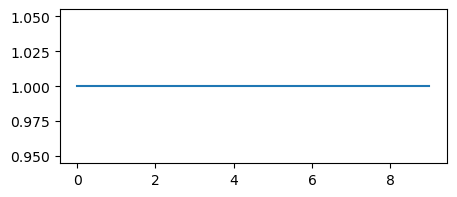

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Descrete impulse
impulse = np.zeros(10)
impulse[1] = 1

# descrete Fourier transform of an impulse:
# a straight line for all the frequencies
fft = np.fft.fft(impulse)

fig, ax = plt.subplots(figsize=(5, 2))
ax.plot(np.abs(fft))
plt.show()

When we feed an input signal $x(t)$ to our filter, the filter outputs modified signal $y(t)$ and
this process can be described by the theory of the [linear time-invariant system](https://en.wikipedia.org/wiki/Linear_time-invariant_system),
which states that filter output $y(t)$ (system response) can be found directly using convolution
$y(t) = x(t) ∗ h(t)$ where $h(t)$ is called the system's impulse response and $∗$ represents convolution.

According to the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem): convolution
in time domain equals to multiplication in the frequency domain (Fourier transformed):

$$
y(t) = x(t) * h(t) \overset{FT}{\longrightarrow} Y(f) = X(f) \cdot H(f)
\tag{4}
$$

The system's impulse response $h(t)$ in the frequency domain is what we call $H(f)$,
which basically gives us our system's frequency response or Bode plot. These are the
main characteristics of our system or filter that we're trying to obtain.

In order to get $H(f)$ we need $X(f)$ to be equal to 1 in frequency domain, so that 

$$
Y(f) = H(f)
$$

We've already derived property $(3)$ of the $\delta(t)$ which is equal to unity in the frequency
domain, so substituting $x(t)$ with the $\delta(t)$ in $(4)$ we get frequency response of the system

$$
y(t) = \delta(t) * h(t) \overset{FT}{\longrightarrow} Y(f) = H(f)
$$

Which means that when we feed an impulse to a filter, we retrieve an impulse response at the filter output,
which will be equal to the system's frequency response after Fourier transform.

## System Impulse Response with RedPitaya

Ultimately, this article aims to present a practical method for obtaining frequency response on RedPitaya hardware,
rather than focusing solely on the theory of digital signal processing. So let's implement some code on Python.

Firstly, let's define the required module imports and the main routine for signal generation and
acquisition of the filter output. The following function interacts with the RedPitaya Python API
and returns the acquired signal on two inpuy channels: CH1 and CH2. Its purpose is solely to facilitate
signal generation and reception on the RedPitaya hardware, deferring the actual signal processing to
subsequent functions.

In [6]:
import time
import numpy as np
from matplotlib import pyplot as plt
from rp_overlay import overlay
import rp

# Generate signal burst on CH1 output and acquire input
# on CH1 and CH2
def rp_generate_and_acquire__with_garbage_on_stdout(signal, N, Fgen, dec, Vscale):
    # Create FPGA
    fpga = overlay()

    # Init
    rp.rp_Init();

    # Reset generation and acquisition
    rp.rp_GenReset()
    rp.rp_AcqReset()

    # Create signal buffer
    buf = rp.arbBuffer(N)
    for i in range(0, N):
        buf[i] = float(signal[i])

    # Set signal as an arbitrary waveform
    rp.rp_GenWaveform(rp.RP_CH_1, rp.RP_WAVEFORM_ARBITRARY)
    rp.rp_GenArbWaveform(rp.RP_CH_1, buf, N)

    # Change to burst mode
    rp.rp_GenMode(rp.RP_CH_1, rp.RP_GEN_MODE_BURST)
    rp.rp_GenBurstCount(rp.RP_CH_1, 1)
    rp.rp_GenFreqDirect(rp.RP_CH_1, Fgen)

    # Specify generator trigger source
    rp.rp_GenTriggerSource(rp.RP_CH_1, rp.RP_GEN_TRIG_SRC_INTERNAL)

    # Enable output synchronisation
    rp.rp_GenOutEnableSync(True)

    # Set decimation for acquisition
    rp.rp_AcqSetDecimation(dec)

    # Set trigger level and delay
    rp.rp_AcqSetTriggerLevel(rp.RP_T_CH_1, 0)
    rp.rp_AcqSetTriggerDelay(8192)

    # Start Acquisition
    rp.rp_AcqStart()

    # Specify trigger - input 1 positive edge
    rp.rp_AcqSetTriggerSrc(rp.RP_TRIG_SRC_AWG_PE)

    # No idea WTF is that, but RedPitaya manuals insist
    # on this sleep
    time.sleep(0.1)

    # Trigger generation
    rp.rp_GenTriggerOnly(rp.RP_CH_1)

    # Wait for triggered state
    while True:
        trig_state = rp.rp_AcqGetTriggerState()[1]
        if trig_state == rp.RP_TRIG_STATE_TRIGGERED:
            break
        time.sleep(0.01)

    # Wait for buffer to be filled
    while True:
        if rp.rp_AcqGetBufferFillState()[1]:
            break
        time.sleep(0.01)

    # Common float buffer
    fbuff = rp.fBuffer(N)

    # Get system input on CH1
    res = rp.rp_AcqGetOldestDataV(rp.RP_CH_1, N, fbuff)[1]
    input = np.zeros(N, dtype = float)
    for i in range(0, N, 1):
        input[i] = fbuff[i]

    # Get system response on CH2
    res = rp.rp_AcqGetOldestDataV(rp.RP_CH_2, N, fbuff)[1]
    response = np.zeros(N, dtype = float)
    for i in range(0, N, 1):
        response[i] = fbuff[i]

    # Remove DC component and scale to HV
    response -= np.mean(response)
    response *= Vscale

    return input, response


    # Add a module to suppress annoying output from RedPitaya guts
    from IPython.utils import io

    # Create FPGA
    with io.capture_output() as captured:
        fpga = overlay()

def rp_generate_and_acquire(*args, **kwargs):
    # Add a module to suppress annoying output from RedPitaya guts
    from IPython.utils import io

    # Supress unexpected stdout
    with io.capture_output() as captured:
        return rp_generate_and_acquire__with_garbage_on_stdout(*args, *kwargs)


The code below creates an impulse, passes it to the hardware, and plots the Fourier transform of the
resulting impulse response. As mentioned earlier, this impulse response should correspond to the
frequency response of the system (filter under analysis).

It's important to note that "it is not possible to produce a perfect impulse to serve as input for testing;
therefore, a brief pulse is sometimes used as an approximation of an impulse. Provided that the pulse
is short enough compared to the impulse response, the result will be close to the true, theoretical,
impulse response" [[1]](https://en.wikipedia.org/wiki/Impulse_response). However, in the case of RedPitaya
(or any other hardware), generating a perfect impulse with an instant transition from 0V to 1V and back is
not feasible. Instead, the output signal exhibits "ringing" effects [[2]](https://en.wikipedia.org/wiki/Gibbs_phenomenon),
impacting the filter response and potentially distorting the final result.

To mitigate this issue, the generated pulse in the code has a finite slew rate and width. While this unpredictably
increases the amplitude of the impulse response above the noise floor (which is beneficial), it also makes it impossible
to accurately calculate the actual gain of the system (which is undesirable).

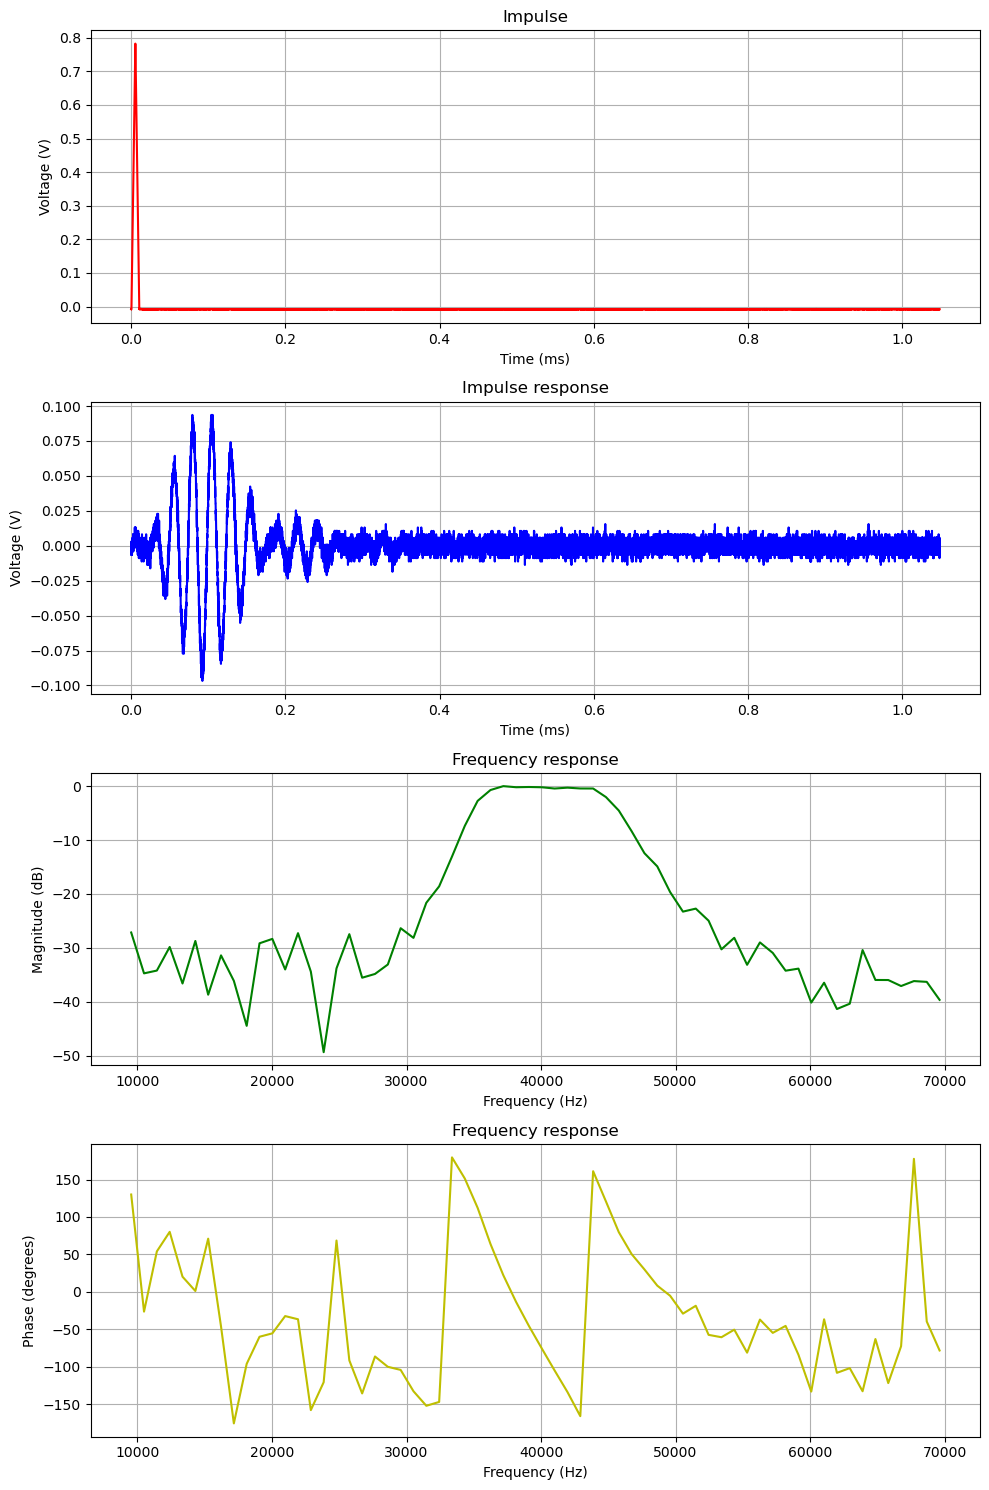

In [7]:
# The maximum amount of the buffer
N = 16384

# Acquisition decimation
dec = rp.RP_DEC_8

# Maximum sampling frequency of the RedPitaya device
Fs = 125e6

# Actual sampling frequency after decimation
Fs = Fs / dec

# Frequency of the whole burst. Set in such a way that
# DAC frequency is equal to the ADC (sampling) frequency
Fgen = Fs / N

# Frequencies of interest
F0 = 10e3
F1 = 70e3

# Jumper switch on the "HV" value on the input channel
Vscale = 20

# Create unity impulse
def create_impulse(N):
    # Create descrete impulse. Unfortunately instant transition
    # 0 -> 1 and 1 -> 0 is impossible to achieve in practice, so
    # we should have some reasonable slew rate emperically derived
    asc_width = 80
    desc_width = 80

    asc  = np.linspace(0, 1, asc_width)
    desc = np.linspace(1, 0, desc_width)
    zeros = np.zeros(N - (asc_width + desc_width))
    impulse = np.concatenate((asc, desc, zeros), dtype=float)

    return impulse

# Return indices of found frequencies in the array
def zoom_frequencies(frq, f0, f1):
    f0_idx = np.abs(frq - f0).argmin()
    f1_idx = np.abs(frq - f1).argmin()
    indices = np.arange(f0_idx, f1_idx + 1)

    return indices

# Zoom to magnitude by threshold in dB and return indices
def zoom_magnitude(magnitude, threshold = -10):
    all_indices = False
    indices = np.argwhere(magnitude > threshold).flatten()
    if len(indices) == 0:
        all_indices = True
        indices = np.argwhere(magnitude).flatten()

    min_frq = np.min(frq[indices])
    max_frq = np.max(frq[indices])
    if not all_indices:
        d = (abs(max_frq) - abs(min_frq)) * 2
        min_frq -= d
        max_frq += d
        min_idx = (np.abs(frq - min_frq)).argmin()
        max_idx = (np.abs(frq - max_frq)).argmin()
        indices = np.arange(min_idx, max_idx)

    return indices

# Create impulse
impulse = create_impulse(N)

# Generate impulse and acquire impulse response
impulse_input, impulse_response = \
    rp_generate_and_acquire(impulse, N, Fgen, dec, Vscale)

# Descrete FT
fft = np.fft.fft(impulse_response)
frq = np.fft.fftfreq(N, d=1/Fs)

# Only positive frequencies
fft = fft[:N//2]
frq = frq[:N//2]

# Normalization. See the 3.4 DFT MAGNITUDES, Richard Lyons
magnitude = np.abs(fft) / N

# In dB, normalize output to the maximum magnitude, so we have 0dB level.
# This is kind of cheating, because impulse input is not strictly a unity
# impulse, but has a slew rate and width, which increases impulse response
# amplitude above noise floor, so actual gain is unknown. Pretend we have 0dB.
max_magnitude = np.max(magnitude)
magnitude_db = 20 * np.log10(magnitude / max_magnitude + 1e-9)

# Zoom to particular frequencies region
fft_indices = zoom_frequencies(frq, F0, F1)

# Time axis in ms
t = np.linspace(0, N * (1/Fs) * 1e3, N)

figure, ax = plt.subplots(4, 1, figsize=(10, 15))

ax[0].set_title("Impulse")
ax[0].set_ylabel("Voltage (V)")
ax[0].set_xlabel("Time (ms)")
ax[0].grid()
ax[0].plot(t, impulse_input, 'r')

ax[1].set_title("Impulse response")
ax[1].set_ylabel("Voltage (V)")
ax[1].set_xlabel("Time (ms)")
ax[1].grid()
ax[1].plot(t, impulse_response, 'b')

ax[2].set_title("Frequency response")
ax[2].set_ylabel("Magnitude (dB)")
ax[2].set_xlabel("Frequency (Hz)")
ax[2].grid()
ax[2].plot(frq[fft_indices], magnitude_db[fft_indices], 'g')

ax[3].set_title("Frequency response")
ax[3].set_ylabel("Phase (degrees)")
ax[3].set_xlabel("Frequency (Hz)")
ax[3].grid()
ax[3].plot(frq[fft_indices], np.rad2deg(np.angle(fft[fft_indices])), 'y')

plt.tight_layout()
plt.show()

The outline of the frequency response plots is quite recognizable, especially near the
passband and center frequency of 40 kHz (compare with Figure 2). However, a significant
amount of noise is immediately noticeable in the impulse response, which negatively impacts
the resulting frequency response by introducing unexpected frequencies and phase fluctuations.

For comparison, Figure 3 displays a theoretical impulse response generated by the FilterCAD software:

![FilterCAD impulse response](img/filtercad-impulse-response.png "FilterCAD impulse response")

*Figure 3*

Remarkably, the real impulse response closely corresponds to the theoretical one (Figure 3), with
matching oscillation periods (for example, observe the oscillation start at 0.2 ms). However, despite
this alignment, the low amplitude of the impulse response, which only slightly exceeds the noise floor,
and the presence of noise (which is not white noise but contains unexpected harmonics), prevent us from
obtaining a smooth frequency response plot similar to the output of the Bode Analyzer (Figure 2).

Let's move on and try another approach.

# Transfer Function of a Chirp Signal

[Transfer function](https://en.wikipedia.org/wiki/Transfer_function) $H(f)$ is another
term that is used to describe the same function that is plotted in the Bode plot and is
another name for frequency response. As mentioned above, the LTI system in frequency domain
is described as the following:

$$
Y(f) = X(f) \cdot H(f)
$$

which can be rearranged as:

$$
H(f) = \frac{Y(f)}{X(f)}
$$

When analyzing a filter as a black box, directly determining the transfer function $H(f)$ may not
be feasible. Instead, the transfer function is typically obtained indirectly by feeding signals
of specific frequencies into the system, sampling the output, and calculating $H(f)$ for each frequency.
This process aligns with the procedure for constructing a Bode plot.

It would indeed be advantageous if it were possible to apply a short waveform to the system input containing
all frequencies within the required range simultaneously, rather than iterating over frequencies with a
certain step. This would allow a complicated analysis of the frequency response of a system in a single
measurement, which could significantly reduce the measurement time and calculations.

Such a sweep signal exists and is called [chirp](https://en.wikipedia.org/wiki/Chirp), characterized by its
continuous change in frequency (as it is a continuous function over a range of $\omega$), resulting in a flat
[chirp spectrum](https://en.m.wikipedia.org/wiki/Chirp_spectrum) for the linear case. Utilizing a chirp signal
significantly simplifies the procedure for calculating $H(f)$, as it requires only a single application of a
chirp signal to the input of the system (filter).

There are several equations for a chirp signal, but we are only interested in the linear one, where the frequency
rate linearly increases over time:

$$
f(t) = f_{0} + ct
$$

where $f_{0}$ is the starting frequency (at time $t = 0$) and $c$ is the chirp rate, assumed constant

$$
c = \frac{f_{1} - f_{0}}{T}
$$

where $f_{1}$ is the final frequency and $T$ is the time it takes to sweep from $f_{0}$ to $f_{1}$ [[1]](https://en.wikipedia.org/wiki/Chirp).

The final equation for linear chirp frequency would be:

$$
f(t) = f_{0} + \frac{f_{1} - f_{0}}{T}t.
$$

Since the phase is the integral of the frequency

$$
\varphi(t) = \varphi(0) + \int_{0}^{T}f(t)dt
$$

the phase of the linear chirp takes the following form:

$$
\varphi(t) = \varphi(0) + f_{0}t + \frac{f_{1} - f_{0}}{2T}t^2.
\tag{5}
$$

## Generate Chirp with RedPitaya

Time to code the linear chirp based on $(5)$, feed it to the filter, sample the response and eventually 
calculate the filter transfer function $H(f)$.

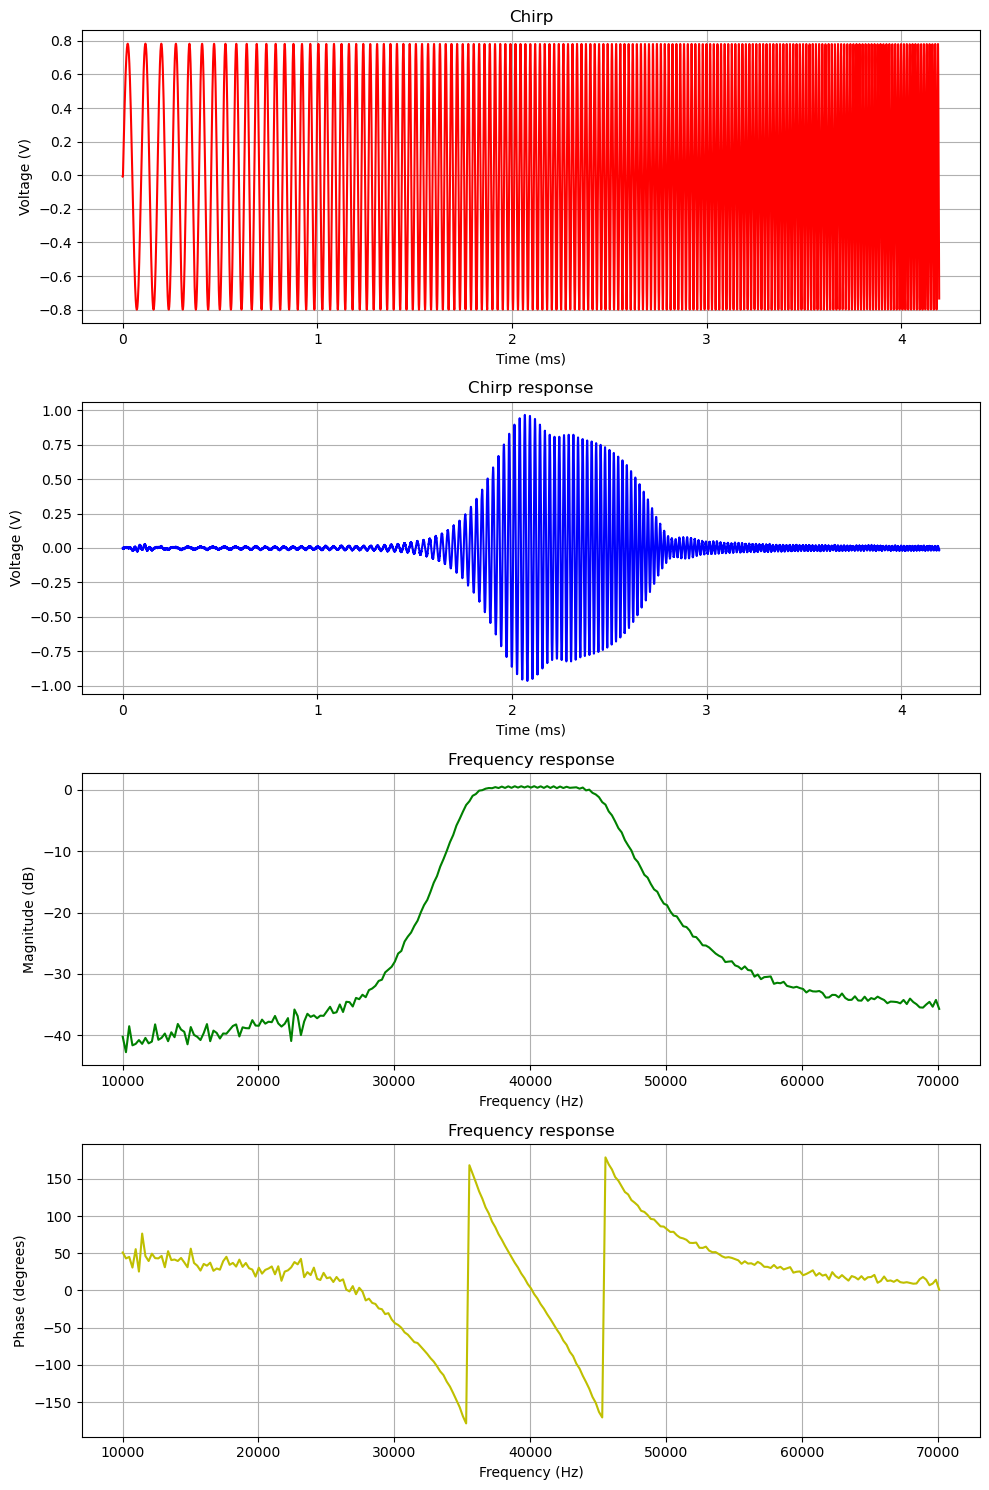

In [8]:
# The maximum amount of the buffer
N = 16384

# Acquisition decimation
dec = rp.RP_DEC_32

# Maximum sampling frequency of the RedPitaya device
Fs = 125e6

# Actual sampling frequency after decimation
Fs = Fs / dec

# Frequency of the whole burst. Set in such a way that
# DAC frequency is equal to the ADC (sampling) frequency
Fgen = Fs / N

# Frequencies of interest
F0 = 10e3
F1 = 70e3

# Jumper switch on the "HV" value on the input channel
Vscale = 20

# Create linear chirp
def create_chirp(N, Fgen, f0, f1):
    def chirp_phase_lin(t, f0, f1):
        return (f0 + (f1 - f0) * t / 2) * t
    f0 = f0 / Fgen
    f1 = f1 / Fgen
    t = np.linspace(0, 1, N, endpoint=False)
    chirp = np.sin(2 * np.pi * chirp_phase_lin(t, f0, f1))

    return chirp

# Create chirp
chirp = create_chirp(N, Fgen, F0, F1)

# Generate chirp and acquire chirp response
chirp_input, chirp_response = \
    rp_generate_and_acquire(chirp, N, Fgen, dec, Vscale)

# FFT of the system input: X(f) = F{x(t)}
input_fft = np.fft.fft(chirp_input)
input_fft = input_fft[:N//2]

# FFT of the system output: Y(f) = F{y(t)}
response_fft = np.fft.fft(chirp_response)
response_fft = response_fft[:N//2]

# FT frequencies
frq = np.fft.fftfreq(N, d=1/Fs)
frq = frq[:N//2]

# Zoom to particular frequencies region
fft_indices = zoom_frequencies(frq, F0, F1)

# Calculate transfer function as H(f) = Y(f) / X(f)
transfer_function = response_fft / input_fft

# Magnitude
magnitude = np.abs(transfer_function)
magnitude_db = 20 * np.log10(magnitude + 1e-9)

# Phase
phase = np.rad2deg(np.angle(transfer_function))

# Time axis in ms
t = np.linspace(0, N * (1/Fs) * 1e3, N)

figure, ax = plt.subplots(4, 1, figsize=(10, 15))
    
ax[0].set_title("Chirp")
ax[0].set_ylabel("Voltage (V)")
ax[0].set_xlabel("Time (ms)")
ax[0].grid()
ax[0].plot(t, chirp_input, 'r')
    
ax[1].set_title("Chirp response")
ax[1].set_ylabel("Voltage (V)")
ax[1].set_xlabel("Time (ms)")
ax[1].grid()
ax[1].plot(t, chirp_response, 'b')
    
ax[2].set_title("Frequency response")
ax[2].set_ylabel("Magnitude (dB)")
ax[2].set_xlabel("Frequency (Hz)")
ax[2].grid()
ax[2].plot(frq[fft_indices], magnitude_db[fft_indices], 'g')
    
ax[3].set_title("Frequency response")
ax[3].set_ylabel("Phase (degrees)")
ax[3].set_xlabel("Frequency (Hz)")
ax[3].grid()
ax[3].plot(frq[fft_indices], phase[fft_indices], 'y')
    
plt.tight_layout()
plt.show()

The transfer function obtained using only one small generated continuous chirp waveform in the 10kHz - 70kHz
frequency range closely resembles the plot (Figure 2) generated by the Bode Analyzer. The chirp response plot
itself is also intreresting for analysis: due to the linearity of the chirp signal, the time axis can be
replaced by the frequency axis. This substitution provides an immediate insight into the frequency response
of the filter at specific frequencies eliminating the need for Fourier transform calculations, which is also
quite advantageous.